In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML

set constant

In [86]:

CHENNELS = 3,
EPOCHS = 5

In [87]:
import tensorflow as tf

# Set your desired image size
IMAGE_SIZE = 244  
BATCH_SIZE = 32  
CHENNELS = 3
EPOCHS = 5

image_directory = '/kaggle/input/eye-data-set-5-class/eye_Data_set'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)




Found 4317 files belonging to 5 classes.


In [88]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal', 'retina_disease']

Image shape

In [89]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())

(32, 244, 244, 3)
(32,)
[2 3 3 1 2 0 0 0 1 3 2 1 1 2 2 0 1 0 2 0 0 3 1 1 1 2 2 3 3 3 1 0]


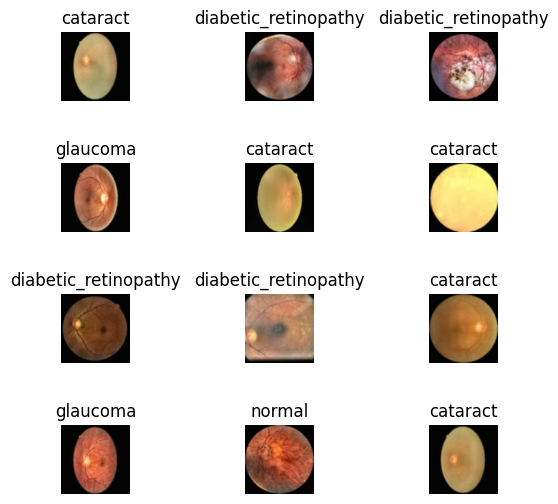

In [90]:
plt.figure(figsize=(6,6))
for image_batch , labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
    plt.subplots_adjust(hspace=0.9, wspace=0.9)

Spliting datast

In [91]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [92]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [93]:
len(train_ds)

108

In [94]:
len(test_ds)

14

In [95]:
len(val_ds)

13

# Prefetch Data

In [96]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building Model

In [97]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 244)
])

Data Augmentation

In [98]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Applying data augmentation on train_ds

In [99]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Archtiecture

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB3  # Import EfficientNetB0
from IPython.display import HTML

IMAGE_SIZE = 244  
BATCH_SIZE = 32  
CHANNELS = 3
EPOCHS = 20
N_CLASSES = 5  # Number of classes

# Assuming the rest of your data preprocessing code remains the same...

# Using EfficientNetB0
base_model = EfficientNetB3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASSES, activation='sigmoid')  # Adjust for the number of classes
])

In [102]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 8, 8, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               196736    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 10980916 (41.89 MB)
Trainable params: 19

In [103]:
model.compile(optimizer='adam',
             loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics= ['accuracy']
             
             )

In [104]:
%%time
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50


2024-01-14 17:21:38.409961: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - 59s 415ms/step - loss: 0.8533 - accuracy: 0.6554 - val_loss: 0.6463 - val_accuracy: 0.7700
Epoch 2/50
108/108 [==============================] - 36s 328ms/step - loss: 0.6397 - accuracy: 0.7393 - val_loss: 0.5770 - val_accuracy: 0.7748
Epoch 3/50
108/108 [==============================] - 36s 331ms/step - loss: 0.5799 - accuracy: 0.7781 - val_loss: 0.4944 - val_accuracy: 0.8184
Epoch 4/50
108/108 [==============================] - 36s 329ms/step - loss: 0.5336 - accuracy: 0.7977 - val_loss: 0.5295 - val_accuracy: 0.8039
Epoch 5/50
108/108 [==============================] - 36s 329ms/step - loss: 0.4985 - accuracy: 0.8056 - val_loss: 0.4591 - val_accuracy: 0.8450
Epoch 6/50
108/108 [==============================] - 36s 328ms/step - loss: 0.4724 - accuracy: 0.8232 - val_loss: 0.4351 - val_accuracy: 0.8426
Epoch 7/50
108/108 [==============================] - 36s 329ms/step - loss: 0.4576 - accuracy: 0.8218 - val_loss: 0.4281 - val_accuracy: 0.8

In [111]:
model.evaluate(test_ds)

14/14 [==============================] - 2s 135ms/step - loss: 0.2815 - accuracy: 0.8929


[0.28148362040519714, 0.8928571343421936]

In [112]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 108}

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [115]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

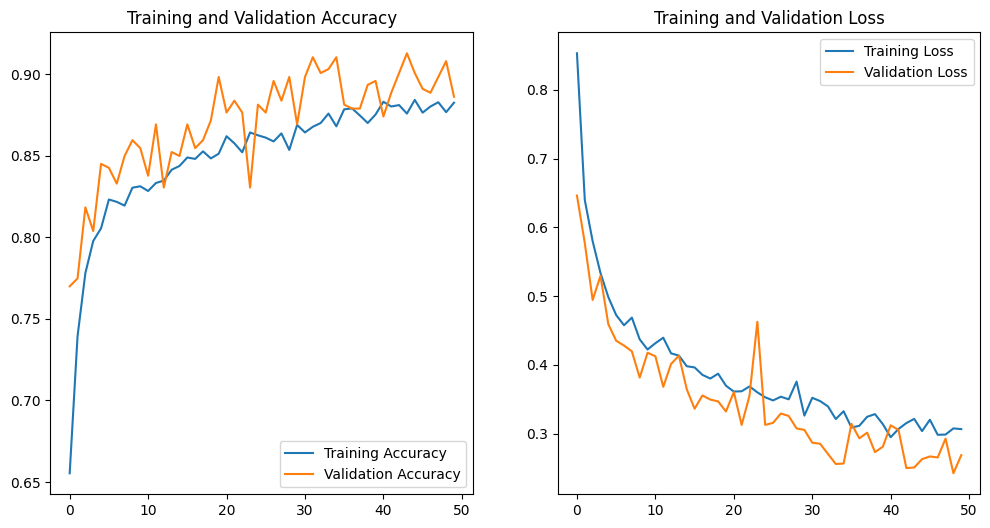

In [116]:
EPOCHS = len(acc)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [117]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Run Prediction on a sample image

first image to predict
actual lable: glaucoma
1/1 [==============================] - 2s 2s/step
prediction label:  glaucoma


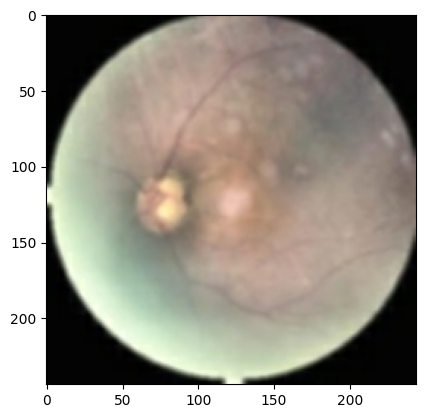

In [118]:
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual lable:' , class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('prediction label: ', class_names[np.argmax(batch_prediction[0])])
    

make prediction interface

1/1 [==============================] - 0s 28ms/step


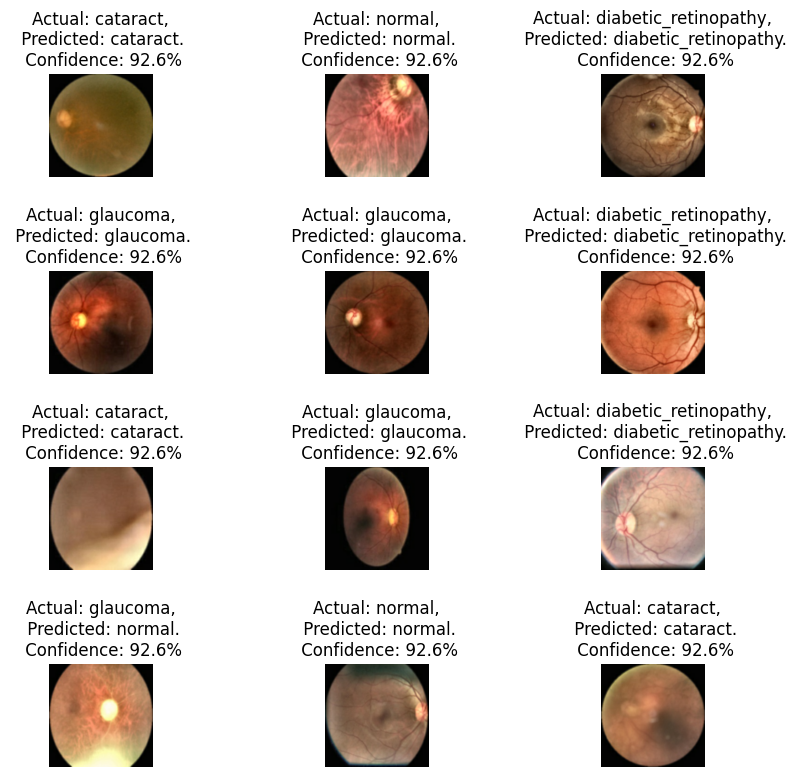

In [119]:
plt.figure(figsize=(9,9))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        prediction_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {prediction_class}.\n Confidence: { confidance}%")
        plt.axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.9, wspace=0.9)
